# 2024/11/31

Balanced class distribution after SMOTEENN: [44693 51647]
Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.92      0.62      0.74     30634
           1       0.20      0.65      0.31      4580

    accuracy                           0.62     35214
   macro avg       0.56      0.64      0.53     35214
weighted avg       0.83      0.62      0.68     35214



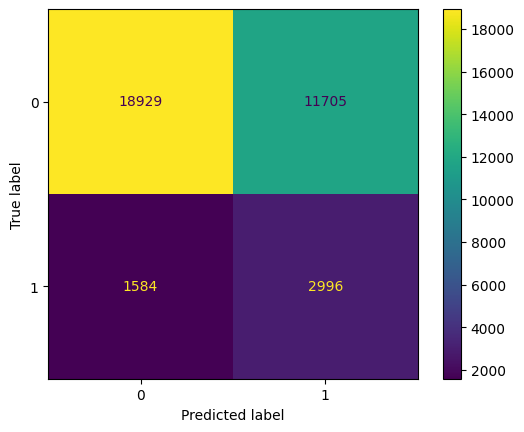

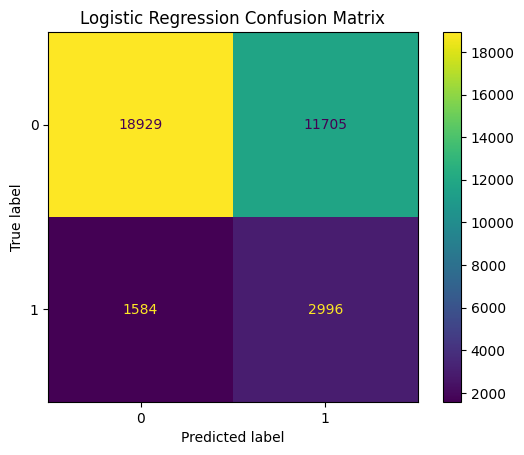

Decision Tree Report:
              precision    recall  f1-score   support

           0       0.94      0.68      0.79     30634
           1       0.24      0.69      0.36      4580

    accuracy                           0.68     35214
   macro avg       0.59      0.68      0.57     35214
weighted avg       0.85      0.68      0.73     35214



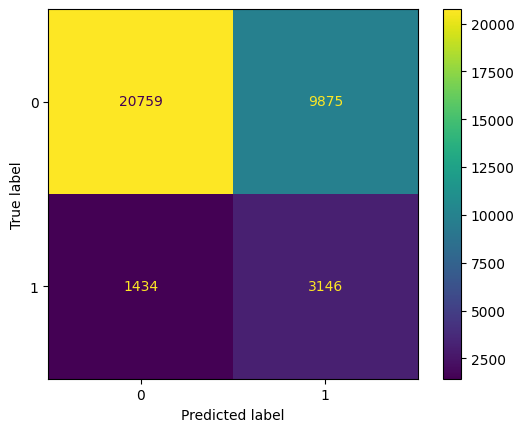

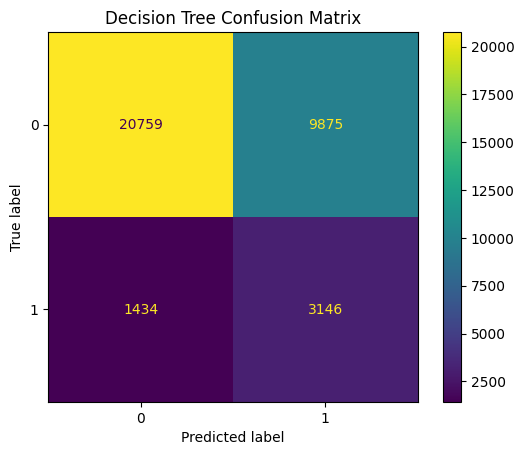

Random Forest Report:
              precision    recall  f1-score   support

           0       0.92      0.79      0.85     30634
           1       0.28      0.55      0.38      4580

    accuracy                           0.76     35214
   macro avg       0.60      0.67      0.61     35214
weighted avg       0.84      0.76      0.79     35214



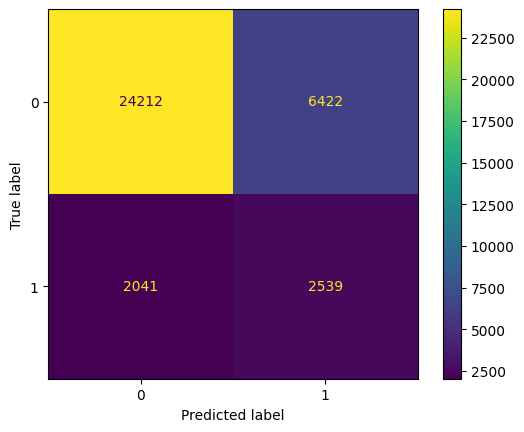

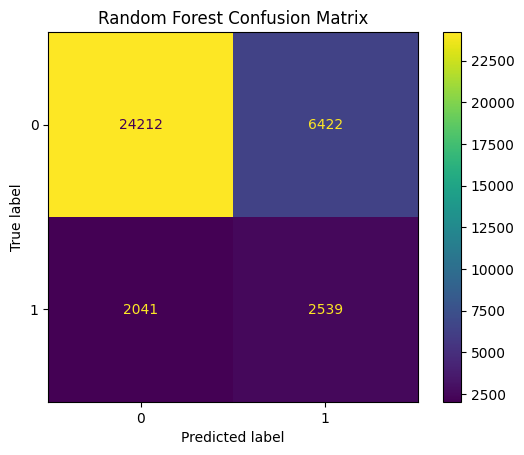

XGBoost Report:
              precision    recall  f1-score   support

           0       0.95      0.61      0.74     30634
           1       0.22      0.76      0.35      4580

    accuracy                           0.63     35214
   macro avg       0.59      0.69      0.54     35214
weighted avg       0.85      0.63      0.69     35214



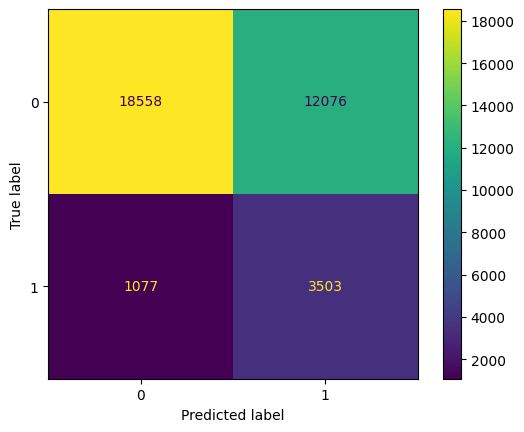

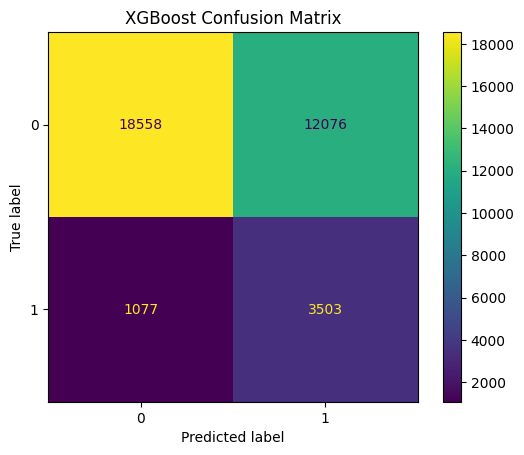

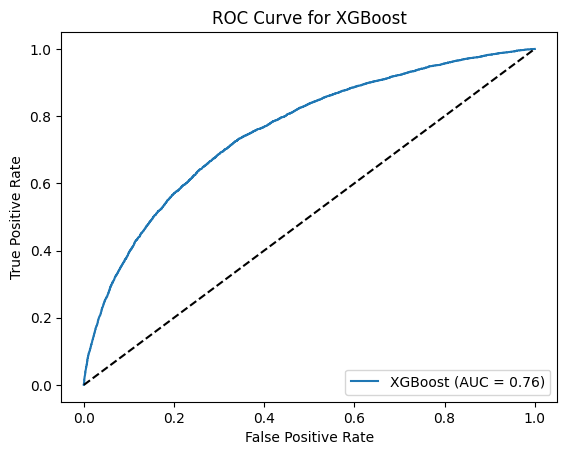

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_curve, auc
from imblearn.combine import SMOTEENN
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

# Combine datasets
file_names = ['Crime_Incidents_in_2019.csv', 'Crime_Incidents_in_2020.csv',
              'Crime_Incidents_in_2021.csv', 'Crime_Incidents_in_2022.csv']
datasets = [pd.read_csv(file) for file in file_names]
for data in datasets:
    data.drop(columns=['OCTO_RECORD_ID', 'BID', 'END_DATE'], inplace=True)

combined_data = pd.concat(datasets, ignore_index=True)

# Generate new features
combined_data['REPORT_DAT'] = pd.to_datetime(combined_data['REPORT_DAT'], errors='coerce')
combined_data['DayOfWeek'] = combined_data['REPORT_DAT'].dt.dayofweek
combined_data['Hour'] = combined_data['REPORT_DAT'].dt.hour
combined_data['IsWeekend'] = combined_data['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

# Define crime category
violent_offenses = ['HOMICIDE', 'ASSAULT W/DANGEROUS WEAPON', 'ROBBERY']
combined_data['IsHotspot'] = combined_data['OFFENSE'].apply(lambda x: 1 if x in violent_offenses else 0)

# Select features and target
features = combined_data[['DayOfWeek', 'Hour', 'LATITUDE', 'LONGITUDE', 'IsWeekend']]
target = combined_data['IsHotspot']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Handle class imbalance
smote_enn = SMOTEENN(random_state=42)
X_train_balanced, y_train_balanced = smote_enn.fit_resample(X_train, y_train)
print("Balanced class distribution after SMOTEENN:", np.bincount(y_train_balanced))

# Logistic Regression
logistic_model = LogisticRegression(class_weight='balanced', C=0.1, random_state=42)
logistic_model.fit(X_train_balanced, y_train_balanced)
y_pred_logistic = logistic_model.predict(X_test)
print("Logistic Regression Report:")
print(classification_report(y_test, y_pred_logistic))
ConfusionMatrixDisplay.from_estimator(logistic_model, X_test, y_test).plot()
plt.title("Logistic Regression Confusion Matrix")
plt.show()

# Decision Tree
tree_model = DecisionTreeClassifier(max_depth=5, random_state=42)
tree_model.fit(X_train_balanced, y_train_balanced)
y_pred_tree = tree_model.predict(X_test)
print("Decision Tree Report:")
print(classification_report(y_test, y_pred_tree))
ConfusionMatrixDisplay.from_estimator(tree_model, X_test, y_test).plot()
plt.title("Decision Tree Confusion Matrix")
plt.show()

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train_balanced, y_train_balanced)
y_pred_rf = rf_model.predict(X_test)
print("Random Forest Report:")
print(classification_report(y_test, y_pred_rf))
ConfusionMatrixDisplay.from_estimator(rf_model, X_test, y_test).plot()
plt.title("Random Forest Confusion Matrix")
plt.show()

# XGBoost
xgb_model = XGBClassifier(n_estimators=100, max_depth=7, scale_pos_weight=5, random_state=42)
xgb_model.fit(X_train_balanced, y_train_balanced)
y_pred_xgb = xgb_model.predict(X_test)
print("XGBoost Report:")
print(classification_report(y_test, y_pred_xgb))
ConfusionMatrixDisplay.from_estimator(xgb_model, X_test, y_test).plot()
plt.title("XGBoost Confusion Matrix")
plt.show()

# ROC Curve for XGBoost
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob_xgb)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f"XGBoost (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for XGBoost')
plt.legend(loc="lower right")
plt.show()
